In [3]:
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [59]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from scipy.io import arff
import xgboost as xgb
pd.options.display.max_columns = None
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics

## Wczytanie danych

In [146]:
df = pd.read_csv("students-all.csv")

In [147]:
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies.head()
df_dummies = df_dummies.iloc[:,1:]
df_dummies.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,major_por
0,18,4,4,2,2,0,4,3,4,1,1,3,6,5,6,6,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0
1,17,1,1,1,2,0,5,3,3,1,1,3,4,5,5,6,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
2,15,1,1,1,2,3,4,3,2,2,3,3,10,7,8,10,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,1,0,0
3,15,4,2,1,3,0,3,2,2,1,1,5,2,15,14,15,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,1,1,1,1,1,0
4,16,3,3,1,2,0,4,3,2,1,2,5,4,6,10,10,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0


## Funkcja ternująca na xgboost

In [104]:
def train_fast(df, max_depth, target ):
    
    """
    From Standard cross validation differs in data partitnion. Due to optimizing model on validation set,
    we get final AUC score from equally big test set.
    """
    
    # shuffling index
    df = df.sample(frac=1).reset_index(drop=True)
    n = len(df)
    
    # 5 fold cross validation
    kf = KFold(n_splits=5)
        
    
    ret = []
    tpr_arr = []
    fpr_arr = []
    
    # we will make test 10% and validation 10%
    for train_index, test_index in kf.split(df):
        
        train = df.iloc[train_index,:]
        
        v_ind = test_index[0:(len(test_index)//2)] 
        t_ind = test_index[(len(test_index)//2):len(test_index)]
        
        validation = df.iloc[v_ind,:]
        test = df.iloc[t_ind,:]
        
        label_train = train[target]
        label_val = validation[target]
        label_test = test[target]

        df_train = train.drop([target], axis = 1)
        df_test  = test.drop([target], axis = 1)
        df_val  = validation.drop([target], axis = 1)
        
        dtrain = xgb.DMatrix(data = df_train, label=label_train)
        dval = xgb.DMatrix(data = df_val, label=label_val)
        dtest = xgb.DMatrix(data = df_test, label=label_val)
        
        param = {'max_depth': max_depth, 'objective': 'binary:logistic', 'eval_metric':'auc'}
        
        evallist = [(dval, 'eval'), (dtrain, 'train')]
        
        num_round = 100
        
        bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=0)
        y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

        fpr, tpr, thresholds = metrics.roc_curve(label_test.to_numpy(), y_pred)

        
        ret.append(metrics.auc(fpr, tpr))
        
        fpr_arr.append(fpr)
        tpr_arr.append(tpr)
        
    # fpr and tpr arrays are problematic, we will get them from median AUC score
    # note that we are returning mean auc score, so it is not ideal 
    index = np.where(np.mean(np.array(ret))== np.mean(np.array(ret)))[0][0]
    
    
    return np.array(ret).mean(), bst, fpr_arr[index],tpr_arr[index]

## Uśrednione auc (nie acc dont worry)

In [24]:
acc_results = []
acc_sum = 0
for i in range(10): 
    acc , bst = train_fast(df_dummies, 13, "romantic_yes")
    acc_sum += acc
acc_results.append(acc_sum/10)
acc_sum = 0

[0]	eval-auc:0.57743	train-auc:0.92682
[50]	eval-auc:0.75919	train-auc:1.00000
[99]	eval-auc:0.77236	train-auc:1.00000
[0]	eval-auc:0.73610	train-auc:0.92640
[50]	eval-auc:0.83787	train-auc:1.00000


/home/jakwisn/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[99]	eval-auc:0.83747	train-auc:1.00000
[0]	eval-auc:0.60580	train-auc:0.93720
[50]	eval-auc:0.82026	train-auc:1.00000
[99]	eval-auc:0.83946	train-auc:1.00000
[0]	eval-auc:0.74327	train-auc:0.92910
[50]	eval-auc:0.91059	train-auc:1.00000
[99]	eval-auc:0.89410	train-auc:1.00000
[0]	eval-auc:0.63221	train-auc:0.92231
[50]	eval-auc:0.81378	train-auc:1.00000
[99]	eval-auc:0.81339	train-auc:1.00000


TypeError: unsupported operand type(s) for +=: 'int' and 'list'

In [22]:
# Zróbmy średnią kroczącą 
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [23]:
a = moving_average(np.array(acc_results),5)

In [24]:
res = pd.DataFrame({"acc":a,"depth":np.arange(len(acc_results))[2:-2]})

Text(0.5, 1.0, 'moving average of accuracy, base = 3')

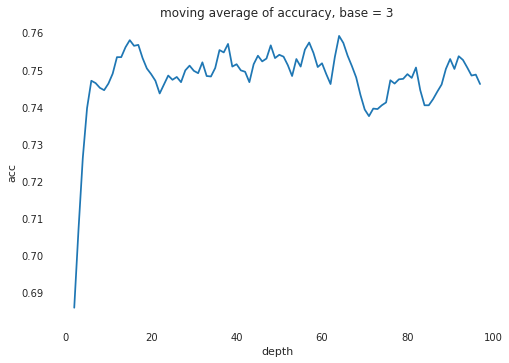

In [25]:
sns.lineplot(data = res, x = "depth", y = "acc").set_title("moving average of accuracy, base = 5")

## Różne encodery

In [42]:
def get_acc_mean(df):
    acc_sum = 0
    for i in range(20):
        acc , bst = train_fast(df, 18)
        acc_sum += acc
    return(acc_sum/20)

In [17]:
import category_encoders as ce

encolums = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'schoolsup_yes', 'famsup_yes', 'paid_yes',
       'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes',
       'major_por']

In [43]:
%%capture
res_dict = {}
encoder = ce.backward_difference.BackwardDifferenceEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["BackwardDifferenceEncoder"] = get_acc_mean(df_encoded)

In [44]:
%%capture
encoder = ce.binary.BinaryEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["BinaryEncoder"] = get_acc_mean(df_encoded)

In [45]:
%%capture
encoder = ce.basen.BaseNEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["BaseNEncoder"] = get_acc_mean(df_encoded)

In [46]:
%%capture
encoder = ce.hashing.HashingEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["HashingEncoder"] = get_acc_mean(df_encoded)

In [47]:
%%capture
encoder = ce.helmert.HelmertEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["HelmertEncoder"] = get_acc_mean(df_encoded)

In [52]:
%%capture
encoder = ce.one_hot.OneHotEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["OneHotEncoder"] = get_acc_mean(df_encoded)

In [53]:
%%capture
encoder = ce.ordinal.OrdinalEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["OrdinalEncoder"] = get_acc_mean(df_encoded)

In [55]:
%%capture
encoder = ce.polynomial.PolynomialEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["PolynomialEncoder"] = get_acc_mean(df_encoded)

In [56]:
%%capture
encoder = ce.sum_coding.SumEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
res_dict["SumEncoder"] = get_acc_mean(df_encoded)

In [57]:
from pprint import pprint
pprint(res_dict)

{'BackwardDifferenceEncoder': 0.743312101910828,
 'BaseNEncoder': 0.7420382165605096,
 'BinaryEncoder': 0.743312101910828,
 'HelmertEncoder': 0.7535031847133757,
 'OneHotEncoder': 0.7719745222929936,
 'OrdinalEncoder': 0.7426751592356687,
 'PolynomialEncoder': 0.7515923566878981,
 'SumEncoder': 0.7585987261146496,
 'hashing.HashingEncoder(': 0.6404458598726113}


## Benchmark - podstawa

Widzimy, że najlepiej wypada model dla głębokości około 40, ale ogólnie charakteryzuje się sporą wariancją wyniku accuracy

In [148]:
def quick_auc_median(df,depth,target):

    auc_array = []
    fpr_array = []
    tpr_array = []

    # musi być nieparzysta! ;)
    iterations = 25

    for i in range(iterations):
        auc, _, fpr_arr, tpr_arr = train_fast(df, depth, target)
        auc_array.append(auc)
        fpr_array.append(fpr_arr) 
        tpr_array.append(tpr_arr)


    print(f'Mediana AUC: {round(np.median(auc_array),4)}')

    return auc_array, fpr_array, tpr_array

Sprawdźmy bazowe `AUC`

In [170]:
auc_array , fpr_array, tpr_array = quick_auc_median(df_dummies, 20,"romantic_yes")

Mediana AUC: 0.8286


In [150]:
# index where median value is
index = np.where(auc_array == np.median(auc_array))[0][0]

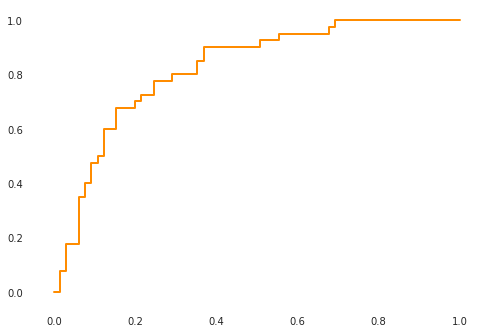

In [151]:
lw = 2
roc_auc = metrics.auc(fpr_array[index], tpr_array[index])
plt.figure()
plt.plot(fpr_array[index], tpr_array[index], color='darkorange',
lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)

plt.show()

## Logarytmowanie zmiennych ciągłych

Jedna zmienna ma rozkład dużo odbiegający od normalnego, przekształćmy ją.

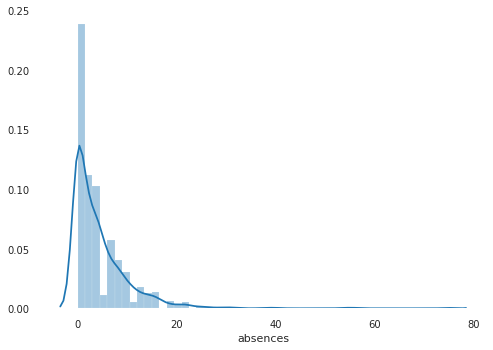

In [152]:
sns.distplot(df_dummies.absences)

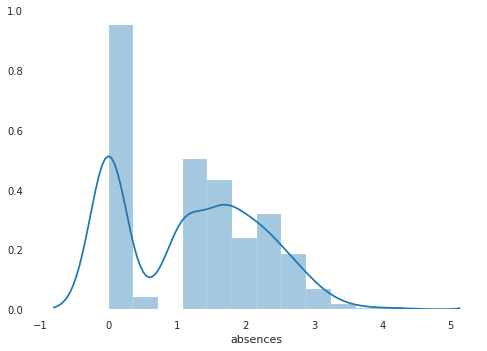

In [153]:
sns.distplot(np.log(df_dummies.absences+1)) # pytanie czy warto, może coś lepszego

In [154]:
df_dummies["absences"] = np.log(df.absences +1)

Sprawdźmy medianę `AUC` po zmianie

In [168]:
auc_array , _, _ = quick_auc_median(df_dummies, 20,"romantic_yes")

Mediana AUC: 0.8397


Trochę lepiej!

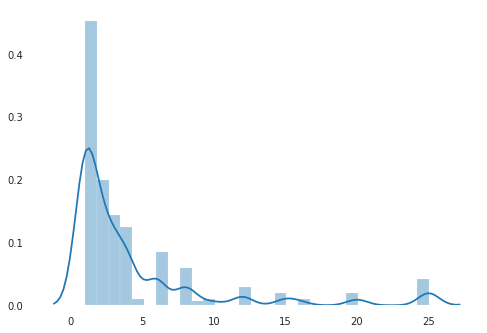

In [160]:
sns.distplot(df_dummies.loc[df_dummies.romantic_yes == 1].Walc * df_dummies.loc[df_dummies.romantic_yes == 1].Dalc)

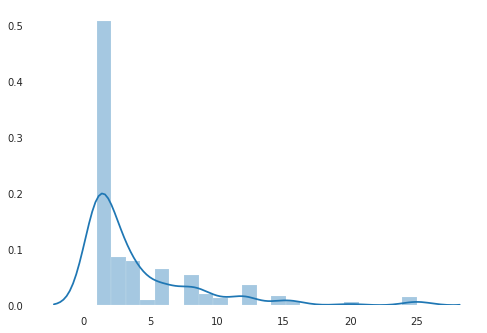

In [161]:
sns.distplot(df_dummies.loc[df_dummies.romantic_yes == 0].Walc * df_dummies.loc[df_dummies.romantic_yes == 0].Dalc)

In [163]:
df_dummies["WeekandEnd"] = df_dummies.Walc * df_dummies.Dalc

In [164]:
a = np.where((df_dummies.Dalc > 3)&(df_dummies.Walc <3),1,0 )   # wniosek z eda, osoby oznaczone w tej kolumnie jako 1, to wyłącznie romantycy
df_dummies["WeirdDrinker"] = a

In [169]:
auc_array , fpr_array, tpr_array = quick_auc_median(df_dummies, 20,"romantic_yes") 

Mediana AUC: 0.8358


Ta zmiana zdaje się nic nie wnosić

## PCA

In [188]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [189]:
pca = PCA(n_components=10) 
X = preprocessing.normalize(df_dummies.drop("romantic_yes", axis = 1), norm='l2')

principalComponents = pca.fit_transform(X)

cols = []
for i in range(10): 
    cols.append("pc"+str(i+1))

principalDf = pd.DataFrame(data = principalComponents, columns = cols)
principalDf

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,0.133842,0.283697,-0.067985,-0.079052,0.128798,0.018826,-0.005779,0.018085,0.012935,0.004488
1,0.134529,0.287312,-0.122219,0.015823,-0.000697,-0.008242,0.011128,0.052255,-0.016777,0.063424
2,0.128834,-0.042732,-0.129686,0.008777,-0.021515,0.021404,0.022562,0.005734,-0.049978,0.029722
3,-0.211432,-0.053861,0.067972,-0.034567,-0.028637,0.039572,0.027683,-0.004114,-0.010486,0.009243
4,-0.003423,0.085860,-0.105848,-0.112036,0.004150,0.062464,-0.062037,0.003460,-0.016332,0.011738
...,...,...,...,...,...,...,...,...,...,...
1039,-0.005607,0.118302,-0.028167,-0.026576,-0.032772,0.030762,-0.025911,0.003140,-0.029379,0.007283
1040,-0.190407,-0.028638,-0.006787,0.079153,0.041379,-0.022013,0.013452,0.002749,-0.003164,0.003389
1041,-0.072759,0.099734,0.003553,0.063838,-0.090179,0.134129,-0.002537,-0.085959,-0.016442,-0.030444
1042,0.247189,-0.174395,-0.028633,0.053885,0.037794,-0.032032,0.012791,-0.041836,-0.003896,-0.042167


In [191]:
pca.explained_variance_ratio_.cumsum()   # 67 % wariancji w 2 ważnych kolumnach

array([0.42656404, 0.67467506, 0.72241182, 0.7581744 , 0.79198726,
       0.81756701, 0.83829407, 0.85615083, 0.8699993 , 0.88336884])

zredukowaliśmy wymiar do 10

In [192]:
pca_df = pd.concat([principalDf,df_dummies.romantic_yes],axis =1)
pca_df

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,romantic_yes
0,0.133842,0.283697,-0.067985,-0.079052,0.128798,0.018826,-0.005779,0.018085,0.012935,0.004488,0
1,0.134529,0.287312,-0.122219,0.015823,-0.000697,-0.008242,0.011128,0.052255,-0.016777,0.063424,0
2,0.128834,-0.042732,-0.129686,0.008777,-0.021515,0.021404,0.022562,0.005734,-0.049978,0.029722,0
3,-0.211432,-0.053861,0.067972,-0.034567,-0.028637,0.039572,0.027683,-0.004114,-0.010486,0.009243,1
4,-0.003423,0.085860,-0.105848,-0.112036,0.004150,0.062464,-0.062037,0.003460,-0.016332,0.011738,0
...,...,...,...,...,...,...,...,...,...,...,...
1039,-0.005607,0.118302,-0.028167,-0.026576,-0.032772,0.030762,-0.025911,0.003140,-0.029379,0.007283,0
1040,-0.190407,-0.028638,-0.006787,0.079153,0.041379,-0.022013,0.013452,0.002749,-0.003164,0.003389,0
1041,-0.072759,0.099734,0.003553,0.063838,-0.090179,0.134129,-0.002537,-0.085959,-0.016442,-0.030444,0
1042,0.247189,-0.174395,-0.028633,0.053885,0.037794,-0.032032,0.012791,-0.041836,-0.003896,-0.042167,0


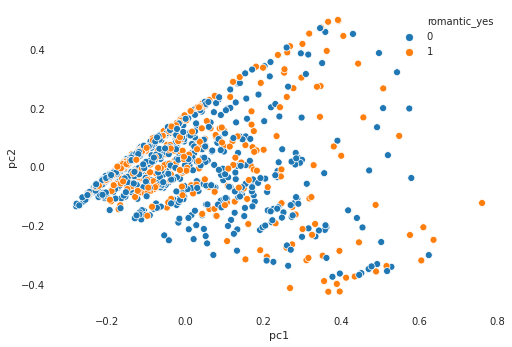

In [193]:
sns.scatterplot(x = "pc1", y = "pc2", data = pca_df, hue = "romantic_yes")  

Nie widać widocznego podziału danych

In [195]:
 _, _,_ = quick_auc_median(pca_df,13,"romantic_yes")

Mediana AUC: 0.5931


In [227]:
df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,major_por,WeekandEnd,WeirdDrinker
0,18,4,4,2,2,0,4,3,4,1,1,3,1.945910,5,6,6,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0
1,17,1,1,1,2,0,5,3,3,1,1,3,1.609438,5,5,6,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0
2,15,1,1,1,2,3,4,3,2,2,3,3,2.397895,7,8,10,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,1,0,0,6,0
3,15,4,2,1,3,0,3,2,2,1,1,5,1.098612,15,14,15,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,1,1,1,1,1,0,1,0
4,16,3,3,1,2,0,4,3,2,1,2,5,1.609438,6,10,10,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,2,0


Czyli najlepsze, bo ok 77% dostaliśmy accuracy modelu z kilkoma dodatkowymi kolumnami. Co jeszcze warto przemyśleć? Standaryzację zmiennych, jaki ma efekt dla modelu (dla tego powinien mieć żaden), na koniec projektu przemyślimy kilka modeli - drzewiaste, sieć nauronową oraz być może k średich. 